In [3]:
# Import Necessary Libraries
import numpy as np
import scipy as sp
import scipy.io

import sys
sys.path.insert(0, '../')
import robustSpectrogram

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools

from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [4]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/robustspec_blocks/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict[wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            ## 04: Get time vector in (seconds)
            time = data['time'][0][0][0]
            
            ## 05: Get freq vector (need to condense)
            freq = data['freq'][0][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict[wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix,
                                          'time': time,
                                          'freq': freq}
            
    data_dict['meta']['description'] = data['description'][0][0][0]
            
    return data_dict

In [6]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034' # change the directories if you want
filedir = '../../condensed_data_' + subj + '/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:] # change which sessions we want
print "Analyzing subject: ", subj
print "The sessions: ", sessions

# loop through each session
for idx, session in enumerate(sessions):
    # the session directory
    sessiondir = filedir + sessions[idx]
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    print "The blocks are: \n", blocks, ' \n'
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 1):
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
        print "All Descriptive Data is Here: \n the word pairs for this session/block: \n", wordpairs
        a_wordpair = wordpairs[0]
        
        print 'Subject: ', subj
        print 'Session: ', session
        print 'Block: ', block
        
        block_data = extractSubjSessionBlockData(subj, session, block)
        numchans = len(block_data['BRICK_CLOCK'].keys())
        print block_data.keys()
        
        print block_data['meta'], '\n\n'
        print "The type of data input for power matrix is: ", type(block_data['BRICK_CLOCK']['1']['powerMat'])
        print "The shape of each power matrix is (approximately): ", block_data['BRICK_CLOCK']['1']['powerMat'].shape \
                , ' events X frequency X time.'
        print "The range of data goes from: ", np.amin(block_data['BRICK_CLOCK']['1']['powerMat']), " to ", np.amax(block_data['BRICK_CLOCK']['1']['powerMat'])
        
        print "There are ", len(block_data['BRICK_CLOCK']['1']['freq']), " frequency points."
        print "There are ", len(block_data['BRICK_CLOCK']['1']['time']), " time points split ", block_data['meta']['description']
        
        break

    break

Analyzing subject:  NIH034
The sessions:  ['session_1', 'session_2']
The blocks are: 
['BLOCK_0', 'BLOCK_1', 'BLOCK_2', 'BLOCK_3', 'BLOCK_4', 'BLOCK_5']  

All Descriptive Data is Here: 
 the word pairs for this session/block: 
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
Subject:  NIH034
Session:  session_1
Block:  BLOCK_0
['BRICK_CLOCK', 'GLASS_JUICE', 'meta', 'JUICE_GLASS', 'CLOCK_BRICK']
{'session': 'session_1', 'description': u'-1 seconds to 5 seconds after probeWordOn', 'block': 'BLOCK_0', 'subject': 'NIH034'} 


The type of data input for power matrix is:  <type 'numpy.ndarray'>
The shape of each power matrix is (approximately):  (20, 100, 30)  events X frequency X time.
The range of data goes from:  -22.519571925  to  6.99170016695
There are  100  frequency points.
There are  29  time points split  -1 seconds to 5 seconds after probeWordOn


# Demonstration of Robust Spectrogram on Data

(100, 30)
(100,)
(29,)


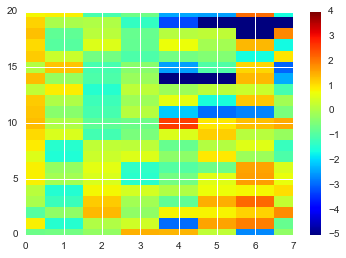

In [34]:
keys = block_data.keys()

for key in keys:
    for chan in np.arange(1, numchans):
        data = np.mean(block_data[key][str(chan)]['powerMat'], axis=0)
        freq = block_data[key][str(chan)]['freq']
        time = block_data[key][str(chan)]['time']
        timeZero = block
        print data.shape
        print freq.shape
        print time.shape
        
#         data = data[]
        plt.imshow(data, origin='lower', interpolation='none', cmap='jet', aspect='auto')
        plt.ylim([0, 20])
        plt.xlim([0, 7])
        plt.clim(-5, 4)
        plt.colorbar()
#         xEst, freq, time, maxIter = robustSpectrogram()
        
        break
    break

In [35]:

print time
print len(freq)

[ 0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.
  3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4  5.6  5.8]
100
